# Академия Аналитиков Авито

# ML для аналитиков

- На предыдущих занятиях вы

- Поговорили про линейные регрессии

![](https://miro.medium.com/v2/resize:fit:888/1*guak1sQTh5sAf46NMzbQig.jpeg)

- Рассмотрели модели Random Forest

![image-3.png](https://pbs.twimg.com/media/FF_ycYDXMAIwDwx.png)

- Попытались оценить качество таких моделей

![image-2.png](https://miro.medium.com/v2/0*WXcZBA71WzPpNLK5.jpg)

## Повторение

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
import scipy as sp
import datetime

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import ar_select_order

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, _TS
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import ParameterGrid
from utilsforecast.plotting import plot_series

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

import warnings
warnings.filterwarnings('ignore')# Чтобы не раздражали

pd.set_option('display.max_columns', None) # Чтобы показывались все колонки
%matplotlib inline

ModuleNotFoundError: No module named 'statsforecast'

In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print ('\nNull Hypothesis: The series has a unit root. Data is NON stationary.')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    print ('\nNull Hypothesis: The process is trend stationary.')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

# опишем функцию, которая будет визуализировать все колонки dataframe в виде line plot
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        if column == 'ds':
            df = df.set_index('ds' )
        if column!='ds':
            trace = go.Scatter(
                x = df.index,
                y = df[column],
                mode = 'lines',
                name = column
            )
            data.append(trace)

    layout = dict(title = title, template='plotly_white')
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

## План
- Временные ряды vs Статичные (перекрестные) данные
- Динамические модели
    - Автокорреляция
    - Тест на автокорреляцию
- Методы работы с временными рядами
    - Стационарность
    - ACF/PACF
    - AR, MA
    - ARIMA
    - SARIMA
    - SARIMAX

## Временные ряды vs Статичные данные

- <span style="color:blue"> Что такое временной ряд? </span>

**Временной ряд** - это последовательность значений какого-либо **параметра**, наблюдаемых в **разные** моменты времени.

- <span style="color:blue">Что тогда такое cross-sectional данные? </span>

**Статичный ряд** - это наблюдения за **объектами** в **один и тот же** период времени.



- <span style="color:blue">Каким свойством обладают перекрестные данные в отличии от временных рядов? </span>

**Статичный ряд** - это наблюдения за *независимыми* объектами в один и тот же период времени.



- <span style="color:blue">В чем же тогда особенность оценки временных рядов?</span>

Одна из ключевых предпосылок для использования МНК в линейных регрессиях - это то, что ошибки распределены независимо друг от друга (отсутствие автокорреляции).
    
Очевидно, что при использовании временных рядов, наблюдения напрямую зависят друг от друга.

При невыполнении этого условия мы получаем неэффективную оценку те бОльшую дисперсию.

Большая дисперсия означает "неправдаподобные" результаты тестов, а значит невозможность провести анализ.

## Динамические модели

- Очень важно, разделять два случая:
$$y_t = \alpha + \beta_1 x_t + \beta_2 x_{t-1} + u_t \\
y_t = \alpha + \beta_1 x_t + \beta_2 y_{t-1} + u_t$$  
- Мы считаем, что $x_t$ не коррелируют с ошибками модели (лаги $x_t$ в том числе не коррелируют)
- Поэтому первую модель можно спокойно посчитать с помощью МНК
- А вот со второй моделью дело обстоит иначе
- Если $u_t$ коррелированы, и мы включили лаговую зависимую переменную, то наши оценки коэффициентов будут не только смещенными, но и не состоятельными (эндогенность)
$$y_t = \alpha + \beta_1 x_t + \beta_2 (\alpha + \beta_1 x_{t-1} + \beta_2 y_{t-2} + u_{t-1}) + u_t$$  


- Проверим, есть ли автокорреляция (зависимость ошибок друг от друга) в первой модели. Для этого воспользуемся данными о потреблении мороженого в США с 18 марта 1951 г. по 11 июля 1953 г:
    - `cons`: потребление мороженого на душу населения
    - `income`: усредненный семейный доход в неделю (в долларах США)
    - `price`: цена мороженного (за пинту)
    - `temp`: усредненная температура (в градусах Фаренгейта)

In [ ]:
icecream = pd.read_csv('practice_08_002.csv')

In [ ]:
icecream.head()

In [ ]:
plotly_df(pd.concat([icecream[['cons', 'price']], icecream[['temp', 'income']]/100], axis = 1))

In [ ]:
icecream['temp_prev'] = icecream['temp'].shift()
icecream_model_lagged = smf.ols('cons ~ price + temp + income + temp_prev', data = icecream).fit()
icecream_model_lagged.summary()

- Чтобы понять, есть ли автокорреляция в такой модели, можно воспользоваться простым тестом (тест Breusch–Godfrey):
    - считаем регрессию и получаем остатки $e$
    - считаем регрессию остатков на все объясняющие переменные и лаги остатков: $e_t = \alpha_1 + \alpha_2 X_t + \rho_1 e_{t-1} + \rho_2 e_{t-2} + ... + \rho_p e_{t-p} + v_t$
    - берем $R^2$ из этой дополнительной (auxiliary) регрессии
    - считаем статистику $BG = (n-p)R^2 \sim \chi_p^2$    
    - $H_0: \rho_1 = \rho_2 = ... = \rho_p = 0$



In [ ]:
endog_icecream_model_lagged=icecream_model_lagged.resid[1:len(icecream_model_lagged.resid)]
exog_icecream_model_lagged=sm.add_constant(
    pd.concat([icecream[['price', 'temp', 'income', 'temp_prev']],
               pd.Series(icecream_model_lagged.resid, name='lag_res').shift()],
              axis = 1).dropna(axis=0))


bg_model_lagged_x = sm.OLS(endog=endog_icecream_model_lagged, exog=exog_icecream_model_lagged).fit()

BG = bg_model_lagged_x.rsquared * (bg_model_lagged_x.nobs - 1)

print('pvalue:' ,1 - sp.stats.chi2.cdf(BG, df = 1))

- А теперь к второй модели
- Допустим мы ее посчитаем

In [ ]:
icecream['cons_prev'] = icecream['cons'].shift()
icecream_model_lagged_y = smf.ols('cons ~ price + temp + income + cons_prev', data = icecream).fit()
icecream_model_lagged_y.summary()

In [ ]:
# достаем остатки
res_lagged_y = icecream_model_lagged_y.resid

endog_icecream_model_lagged_y=res_lagged_y[1:len(res_lagged_y)]
exog_icecream_model_lagged_y = sm.add_constant(pd.concat([icecream[['price', 'temp', 'income', 'cons_prev']],
                                                  pd.Series(res_lagged_y, name='lag_res').shift()],
                                                 axis = 1).dropna(axis=0))

bg_model = sm.OLS(endog=endog_icecream_model_lagged_y, exog=exog_icecream_model_lagged_y).fit()

BG = bg_model.rsquared * (bg_model.nobs - 1)

print('pvalue:' ,1 - sp.stats.chi2.cdf(BG, df = 1))

## Промежуточные итоги

Мы с вами:
- узнали, что основное отличие временных рядов от статичных данных заключается в наличии автокорреляции
- научились тестировать на наличие автокорреляции
- узнали, что добавление лагов регрессоров не страшно, а вот лагов зависимой переменной может привести к проблемам

# Методы работы с временными рядами

## Стационарность

- Стационарность - это такое замечательное свойство, что средние, дисперсии и ковариации ряда не зависят от ряда:
    - $E(y_t) = \mu < \infty$
    - $var(y_t) = E((y_t - \mu)^2) = \gamma_0$
    - $cov(y_t, y_{t-k}) = E\{(y_t - \mu)(y_{t-k} - \mu)\} = \gamma_k$

- А как вообще выглядит нестационарный и стационарный ряды?

![img](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

- Попробуем сгенерировать стационарный и нестационарный ряд, чтобы показать, почему стационарность важна.

In [ ]:
stationary = []
nonstationary = []

for i in range(1000):
    if i == 0:
        stationary.append(np.random.normal(loc = 0, scale = 1, size = 1))
    else:
        stationary.append(1 + 0.99*stationary[i-1] + np.random.normal(loc = 0, scale = 1, size = 1))

for i in range(1000):
    if i == 0:
        nonstationary.append(np.random.normal(loc = 0, scale = 1, size = 1))
    else:
        nonstationary.append(1 + 1*nonstationary[i-1] + np.random.normal(loc = 0, scale = 1, size = 1))

In [ ]:
plt.plot(pd.concat([pd.Series(stationary, name = 'stationary'),
                    pd.Series(nonstationary, name = 'nonstationary')],
                   axis = 1))
plt.legend(['stationary', 'nonstationary'])
plt.show()

- Ну, что же, кажется работать с рядом, который не "взлетает" со временем, а сходится к своему среднему значению, работать лучше

- Вторая важная вещь - это автокорреляционная функция (ACF). На самом деле это очень простая концепция, которая показывает корреляцию во времени между $y_t$:  
$$\rho_k = \frac{cov(y_t, y_{t-k})}{var(y_t)} = \frac{\gamma_k}{\gamma_0}$$  
- Из автокорреляционной функции мы можем сделать вывод о степени коррелированности одной из величин процесса с предшествующими величинами, и, таким образом, продолжительность и силу памяти процесса

$$y_t = 1 + 0.99*y_{t-1}+e_t$$



In [ ]:
plot_acf(np.array(stationary))
plt.show()

- Третья важная вещь - это частичная автокорреляционная функция (PACF), которая показывает корреляцию во времени между $y_t$, изолируя корреляционный эффект промежуточных лагов.   

In [ ]:
plot_pacf(np.array(stationary))
plt.show()

In [ ]:
plt.plot(stationary)
plt.show()

$$y_t = 1 + 0.99*y_{t-1}+e_t$$

$$E(y_t) = E(1 + 0.99*y_{t-1}+e_t)$$

$$E(y_t) = 1 + 0.99*E(y_{t-1})+E(e_t)$$

$$E(y_t) = 1 + 0.99*E(y_{t})$$

$$E(y_t) = \frac{1}{1-0.99} = 100$$

- Собственно стационарный процесс был построен таким образом, что: $y_t = 1 + 0.99 \cdot y_{t-1} + v_t$, поэтому неудивительно, что ACF так медленно затухает

### Общие процессы ARMA

- Мы рассмотрим следующие основные процессы:
    - $MA(q): y_t = \alpha_1 u_{t-1} + \alpha_2 u_{t-2} + ... + \alpha_q u_{t-q} + u_t$
    - $AR(p): y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_p y_{t-p} + u_t$
    - $ARMA(p, q): y_t = \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_p y_{t-p} + \alpha_1 u_{t-1} + \alpha_2 u_{t-2} + ... + \alpha_q u_{t-q} + u_t$

- Думаю, вы заметили, что ранее мы с вами уже несколько раз видели $AR(1)$ процесс
- А чуть выше видели его график и ACF
- Давайте посмотрим на $MA(1)$ и $ARMA(1, 1)$ процессы:
    - $MA(1): y_t = \alpha_1 u_{t-1} + u_t$
    - $ARMA(1, 1): y_t = \beta_1 y_{t-1} + \alpha_1 u_{t-1} + u_t$

In [4]:
eps = np.random.normal(loc = 0, scale = 1, size = 1000)

In [ ]:
ma = []
for i in range(1000):
    if i == 0:
        ma.append(eps[i])
    else:
        ma.append(eps[i] + 0.5 * eps[i-1])

In [ ]:
plt.plot(pd.Series(ma, name = 'MA(1)'))
plt.legend(['MA(1)'])
plt.show()

In [ ]:
plot_acf(np.array(ma))
plot_pacf(np.array(ma))
plt.show()

In [8]:
arma = []
for i in range(1000):
    if i == 0:
        arma.append(eps[i])
    else:
        arma.append(eps[i] + arma[i-1] - 0.9 * eps[i-1])

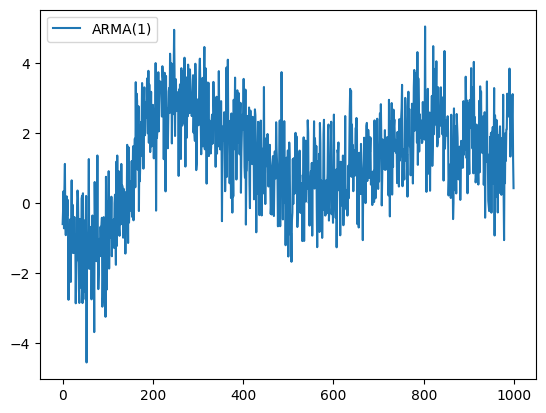

In [9]:
plt.plot(pd.Series(arma, name = 'ARMA(1)'))
plt.legend(['ARMA(1)'])
plt.show()

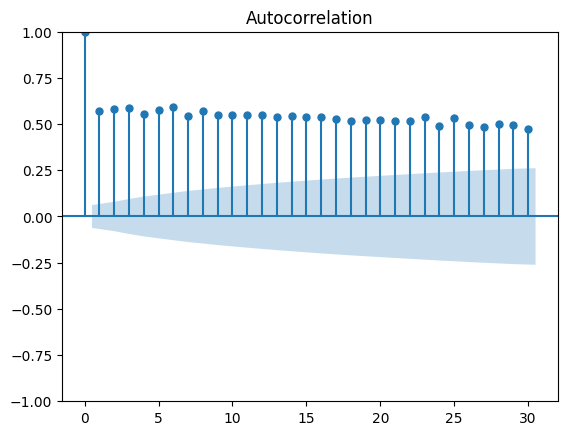

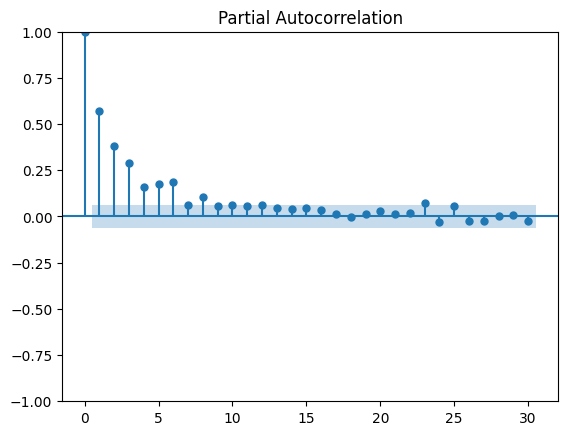

In [10]:
plot_acf(np.array(arma))
plot_pacf(np.array(arma))
plt.show()

- На самом деле, ACF и PACF могут быть очень полезны именно для определения количества лагов AR и MA частей:

![](https://www.researchgate.net/publication/340142416/figure/fig1/AS:872982503247872@1585146656484/ACF-and-PACF-for-ARMAp-q-This-illustrated-that-the-pacf-is-zero-after-p-terms-for-ARp.ppm)

### ARIMA

- Тем не менее, на практике нам не всегда будут встречаться стационарные временные ряды.
- Надо бы подумать над тем:
    - Как тестировать на стационарость
    - Если ряд не стационарен, можно ли его привести к стационарному

Для этого (и для всех предстоящих упражнений) будем использовать следющие данные ([подробнее](https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data)):

Данные о продажах товаров в различных гипермаркетах Favorita в Эквадоре. Corporación Favorita включает в себя сеть гипермаркетов, а также развивает деятельность в сфере производства продуктов питания, электроэнергии и других товаров первой необходимости. Этот набор данных достаточно репрезентативен, так как содержит множество эффектов, которые вы видите в реальных данных. Например, эффект выходных и праздников, сезонность, влияние внешних факторов.

В нашем случае, мы будем пытаться прогнозировать общий обьем продаж для всей сети гипермаркетов.

In [ ]:
#предварительная сборка данных

# df_train = pd.read_csv('train.csv', parse_dates=['date'])
# df_stores = pd.read_csv('stores.csv')
# df_item = pd.read_csv('items.csv')

# df_train = pd.merge(df_train, df_item, on='item_nbr',how='left')
# df_train = pd.merge(df_train, df_stores, on='store_nbr',how='left')

# df_full = pd.pivot_table(df_train, values='unit_sales', index=['date','city', 'state','type','family'],
#                aggfunc='sum').reset_index()

# df_full.to_csv('train_data.csv')

In [ ]:
# Получение и обработка исходных данных.
sales_train_raw = pd.read_csv('train_data.csv', parse_dates=['date'])

In [ ]:
sales_train_raw

In [ ]:
sales_train = pd.pivot_table(sales_train_raw, index='date', values='sales', aggfunc=sum).reset_index()
sales_train.columns = ['ds', 'y']

In [ ]:
validation_horizon = 180
data = sales_train[sales_train['ds']<=(max(sales_train['ds']) - datetime.timedelta(days=validation_horizon))]
data_evaluation = sales_train

Для начала попробуем смоделировать обычную ARIMA на наших данных

In [ ]:
# Посмотрим на первоначальные данные
plotly_df(data.set_index('ds')[['y']])

In [ ]:
print(plot_acf(data.y))

In [ ]:
adf_test(data.y)

Что же такое Unit Root?
- По сути, это наличие лага зависимой переменной с коэффициентом равным единице:

$$y_t = 1 + \color{red}{y_{t-1}} - 0.8*y_{t-2}+e_t$$

- Попробуем вычесть лаг зависимой переменной из обоих частей уравнения:

$$y_t - y_{t-1} = 1 + \color{red}{y_{t-1}} - 0.8*y_{t-2}+e_t - y_{t-1}$$

$$y_{diff}  = 1 - 0.8*y_{t-2}+e_t $$

- Параметр, отвечающий за единичный корень - $d$

$$ARIMA (p,d,q) = ARIMA (1,1,0)$$

In [ ]:
kpss_test(data.y)

In [ ]:
data['y_diff'] = data.y.diff().dropna()

In [ ]:
# Посмотрим еще раз на первоначальные данные
plotly_df(data.set_index('ds')[['y_diff']])

In [ ]:
print(plot_acf(data['y_diff'].dropna()))
print(plot_pacf(data['y_diff'].dropna()))

In [ ]:
print(adf_test(data['y_diff'].dropna()),'\n')
print(kpss_test(data['y_diff'].dropna()))

Кажется, что оба теста (ADF, KPSS) сигнализируют о том, что ряд стационарен, однако мы по прежнему наблюдаем сильную сезонность, которую заметно как на графкие временного ряда, так и на графике ACF. Попробуем избавиться от сезонности.

In [ ]:
data['y_diff_7'] = data.y.diff().diff(7).dropna()

In [ ]:
# Посмотрим еще раз на первоначальные данные
plotly_df(data.set_index('ds')[['y_diff_7']])

In [ ]:
print(plot_acf(data['y_diff_7'].dropna(),lags=30))
print(plot_pacf(data['y_diff_7'].dropna(),lags=30))

In [ ]:
print(adf_test(data['y_diff_7'].dropna()),'\n')
print(kpss_test(data['y_diff_7'].dropna()))

### Выбор модели

- Итак, мы научились тестировать на стационарность, а затем приводить к стационарности, если потребуется
- Однако, мы не знаем, сколько лагов нам брать. ARMA(1, 2)? ARMA(0, 2)? ARMA(5, 100)?
- Чаще всего, на практике используют либо критерий Акаике (Akaike, 1973) - AIC, либо байесовский информационный критерий Шварца (Schwarz, 1978) - BIC.
- In a nutshell, эти критерии измеряют фит модели, контролируя количество используемых ковариат.
- Можем перебирать все варианты, но есть шорткат: используем функцию [AutoArima из библиотеки StatsForecast](https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#autoarima-2)

In [ ]:
# ?AutoARIMA

In [ ]:
model1 = AutoARIMA(
    max_p = 8,
    max_q = 8,
    max_d = 2,
#     start_p = 3,
#     start_q = 3,
#     start_d = 1,
    ic = 'aicc',
    trace = True,
    stepwise = True,
    seasonal=False,
    approximation=True
    )


model1.fit(y=data['y'].values, X=None)

In [ ]:
print("Chosen ARIMA specification:")
print(f"AR order (p): {model1.model_['arma'][0]}")
print(f"Differencing order (d): {model1.model_['arma'][5]}")
print(f"MA order (q): {model1.model_['arma'][1]}")
print(f"\nCoefficients: {model1.model_['coef']}")


In [ ]:
best_arima = ARIMA(data['y'].dropna(), order=(8, 1, 4))
best_arima =  best_arima.fit()
best_arima.summary()

Как же понять, что наша модель действительно работает?

- Важным тестом для диагностики моделей временных рядов также является тест Льюнга—Бокса (Ljung, Box, 1978)
- Тест используется для проверки наличия автокорреляции в остатках модели временных рядов на заданном количестве лагов.
- Нулевая гипотеза теста заключается в том, что остатки модели не автокоррелированы, то есть они являются случайными.

Статистика теста Льюнга-Бокса \( Q \) рассчитывается по формуле:

$$ Q = n(n + 2) \sum_{k=1}^h \frac{\rho_k^2}{n - k} $$

где:
- $n$ — объем выборки,
- $h$ — количество лагов, для которых проверяется автокорреляция,
- $\rho_k$ — коэффициент автокорреляции для лага $k$.

In [ ]:
acorr_ljungbox(best_arima.resid, return_df=True)


- Помимо теста важно провести и визуальную диагностику. Убедиться, что в остатках нет автокорреляции и они стационарны.

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = best_arima.resid[8:].plot()


In [ ]:
print(plot_acf(best_arima.resid))
print(plot_pacf(best_arima.resid))

In [ ]:
forecast_sarima = best_arima.predict()
forecast_sarima

forecast_test_sarima = best_arima.forecast(validation_horizon)

In [ ]:
data_predicted_arima = pd.concat([data,forecast_sarima,forecast_test_sarima, data_evaluation['y']], axis=1)
data_predicted_arima.columns = ['ds', 'y', 'y_diff', 'y_diff_7', 'yhat', 'forecast_arima','y_validation']

In [ ]:
plotly_df(data_predicted_arima[['y','y_validation','yhat','forecast_arima']])


**А что если попробовать SARIMA?**

### Seasonal ARIMA

Seasonal ARIMA - модель очень похожая на классическую ARIMA, за исключением того, что SARIMA позволяет так же моделировать и сезонные компоненты ARIMA.

![image.png](https://miro.medium.com/max/1400/1*yxe5Sf5JSAROq-UVgMLtmA.png)

Формула:

![image.png](https://miro.medium.com/max/1400/1*0A5Y8uQlGcVe6QpOGonZpw.png)

Пример: SARIMA(1, 0 , 1)(1,0,1) - $y_t = c + \alpha y_{t-1}+\theta_0*e_t+\theta_1*e_{t-1} + \alpha_7 y_{t-7}+\theta_7*e_{t-7}$

In [ ]:
model2 = AutoARIMA(
    max_p = 8,
    max_q = 8,
    max_d = 1,
    max_P = 5,
    max_Q = 5,
    max_D = 1,
    seasonal=True,
    season_length = 7,
#     start_p = 3,
#     start_q = 3,
#     start_d = 1,
    ic = 'aicc',
    trace = True,
    stepwise = True,
    approximation=True
    )


model2.fit(y=data['y'].values, X=None)

In [ ]:
model_res = model2.model_
print("Chosen ARIMA specification:")
print(f"AR order (p): {model_res['arma'][0]}")
print(f"Differencing order (d): {model_res['arma'][5]}")
print(f"MA order (q): {model_res['arma'][1]}")
print(f"Seasonal AR order (P): {model_res['arma'][2]}")
print(f"Seasonal Differencing order (D): {model_res['arma'][6]}")
print(f"Seasonal MA order (Q): {model_res['arma'][3]}")
print(f"\nCoefficients: {model_res['coef']}")


In [ ]:
%%time

best_arima = ARIMA(data.y, order=(1,1,2), seasonal_order=(1,0,5,7))
best_arima =  best_arima.fit()
best_arima.summary()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = best_arima.resid[10:].plot()

In [ ]:
print(plot_acf(best_arima.resid.dropna()))
print(plot_pacf(best_arima.resid.dropna()))

In [ ]:
acorr_ljungbox(best_arima.resid, return_df=True)

In [ ]:
forecast_sarima = best_arima.predict()
forecast_sarima

forecast_test_sarima = best_arima.forecast(validation_horizon)

In [ ]:
data_predicted_s = pd.concat([data,forecast_sarima,forecast_test_sarima, data_evaluation['y']], axis=1)
data_predicted_s.columns = ['ds', 'y', 'y_diff', 'y_diff_7', 'yhat', 'forecast_s','y_validation']

In [ ]:
data_predicted_s['forecast_s'] = data_predicted_s['forecast_s']

In [ ]:
plotly_df(data_predicted_s[['y','y_validation','yhat','forecast_s']])


Наконец, давайте попробуем использовать внешние, экзогенные факторы в качестве дополнительных ковариат.

### SARIMAX

SARIMAX - модель, повторяющая функциональную форму SARIMA, за исключением того, что SARIMAX позволяет так же использовать экзогенные переменные в качестве регрессоров.

Формула:
![png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*rXIngrG6Ss-VuJcYrImiig.png)

В качестве внешних данных мы будем использовать ежедневные котировки цены на нефть. Эквадор - страна, зависимая от нефти, и экономика эквадора сильно зависит от скачков цены на нефть.

In [ ]:
df_oil = pd.read_csv('oil.csv', parse_dates=['date'])

df_oil['oil'] = df_oil['dcoilwtico'].interpolate(method='polynomial', order=2,limit_direction='both')
df_oil = df_oil.drop(columns=['dcoilwtico'])

df_oil = df_oil.rename(columns={"date": "ds"}).dropna()

In [ ]:
plotly_df(df_oil.set_index('ds'))

Чтобы понять, сколько лагов X включить в модель, рассмотрим ACF и PACF этого ряда.

In [ ]:
print(plot_acf(df_oil['oil']))
print(plot_pacf(df_oil['oil']))

In [ ]:
adf_test(df_oil['oil'])

In [ ]:
kpss_test(df_oil['oil'])

In [ ]:
df_oil['oil_diff'] = df_oil['oil'].diff().dropna()

In [ ]:
# Посмотрим еще раз на первоначальные данные
plotly_df(df_oil.set_index('ds')[['oil_diff']])

In [ ]:
print(plot_acf(df_oil['oil_diff'].dropna()))
print(plot_pacf(df_oil['oil_diff'].dropna()))

In [ ]:
print(adf_test(df_oil['oil_diff'].dropna()),'\n')
print(kpss_test(df_oil['oil_diff'].dropna()))

In [ ]:
df_oil['oil_lag1'] = df_oil['oil'].shift(1)
df_oil['oil_lag2'] = df_oil['oil'].shift(2)

df_oil = df_oil.dropna()

df_oil

In [ ]:
exog_vars = ['oil', 'oil_lag1']

data_x = data[['ds', 'y']].merge(df_oil[['ds']+exog_vars],
                    on='ds', how='left')
data_evaluation_x = data_evaluation[['ds', 'y']].merge(df_oil[['ds']+exog_vars],
                                          on='ds', how='left')
data_x

In [ ]:
data_x[exog_vars] = data_x[exog_vars].interpolate(method='linear', axis=0,limit_direction='both')
data_evaluation_x[exog_vars] = data_evaluation_x[exog_vars].interpolate(method='linear', axis=0,limit_direction='both')
data_x

In [ ]:
df_oil.iloc[:,1:].corr()

In [ ]:
df_ts = data_x.copy()

df_ts['y_sc'] = (df_ts['y']-np.nanmin(df_ts['y']))/(np.nanmax(df_ts['y'])-np.nanmin(df_ts['y']))
df_ts['y_sc_ma'] = df_ts['y_sc'].rolling(window=7).mean()
df_ts['oil_sc'] = (df_ts['oil']-np.nanmin(df_ts['oil']))/(np.nanmax(df_ts['oil'])-np.nanmin(df_ts['oil']))

plotly_df(df_ts[['ds','y_sc','oil_sc','y_sc_ma']].set_index('ds'))



In [ ]:
# # С помощью автоматического перебора, подберем спецификацию SARIMAX

model3 = AutoARIMA(
    max_p = 8,
    max_q = 8,
    max_d = 1,
    max_P = 5,
    max_Q = 5,
    max_D = 1,
    seasonal=True,
    season_length = 7,
#     start_p = 3,
#     start_q = 3,
#     start_d = 1,
    ic = 'aicc',
    trace = True,
    stepwise = True,
    approximation=True
    )


model3.fit(y=data_x['y'].values, X=data_x[['oil']].values)


In [ ]:
best_arima = ARIMA(endog=data_x[['y']], exog=data_x[exog_vars], order=(1,1,1), seasonal_order=(1,0,4,7))
best_arima =  best_arima.fit()
best_arima.summary()

In [ ]:
print(plot_acf(best_arima.resid.dropna()))
print(plot_pacf(best_arima.resid.dropna()))

In [ ]:
acorr_ljungbox(best_arima.resid, return_df=True)

In [ ]:
forecast_sarima = best_arima.predict()
forecast_start = data_evaluation_x.shape[0]-validation_horizon

forecast_test_sarima = best_arima.forecast(validation_horizon, exog=data_evaluation_x[exog_vars][forecast_start:])

In [ ]:
data_predicted_x = pd.concat([data_x,forecast_sarima,forecast_test_sarima, data_evaluation_x['y']], axis=1)
data_predicted_x.columns = ['ds', 'y'] +exog_vars+ [ 'yhat', 'forecast_x','y_validation']

In [ ]:
data_predicted_x['forecast_x'] = data_predicted_x['forecast_x']

In [ ]:
plotly_df(data_predicted_x[['y','y_validation','yhat','forecast_x']])


Итого, мы получили 3 прогноза: ARIMA, SARIMA, SARIMAX. Попробуем сравнить их на одном графике.



In [ ]:
data_predicted_all = data_predicted_arima[['y_validation','forecast_arima']].merge(
    data_predicted_x[['forecast_x']], left_index=True, right_index=True).merge(
    data_predicted_s[['forecast_s']], left_index=True, right_index=True)

In [ ]:
data_predicted_all

In [ ]:
plotly_df(data_predicted_all[['y_validation','forecast_arima','forecast_x','forecast_s']])


Но как мы можем их сравнить?
Подробно об этом поговорим на следующей лекции, но вот небольшой sneak-peek.

Чаще всего для оценки качества временных рядов используется ошибка MAPE. Во-первых благодаря тому, что эта ошибка подходит практически для любых временных рядов, а во-вторых, потому что она очень легко интерпретируема.

$$\text{ Mean absolute percentage error: }  MAPE = mean(\frac{|y_t - \hat{y_t}|}{y_t})$$

Посчитаем MAPE для наших моделей.

In [ ]:
for model in ['arima', 'x', 's']:
    mape = np.mean(abs(data_predicted_all['forecast_{}'.format(model)]-data_predicted_all['y_validation'])/data_predicted_all['y_validation'])
    print('Model {} MAPE is {}'.format(model,mape))


thoughts?

In [ ]:
# data_predicted_all.to_csv('data_predicted_class_15.csv',index=False)